<a href="https://colab.research.google.com/github/mschoi12/youtube-cnn-002-pytorch-unet/blob/master/pose_acc_240917.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


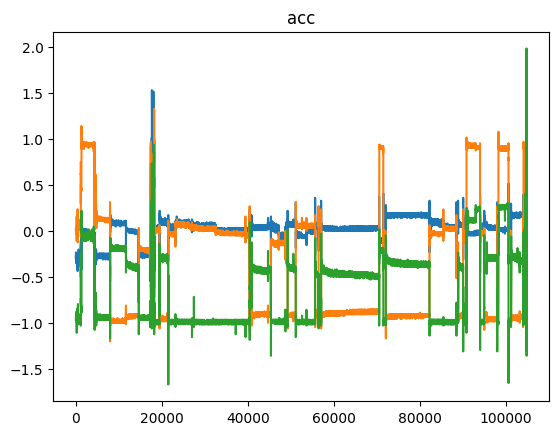

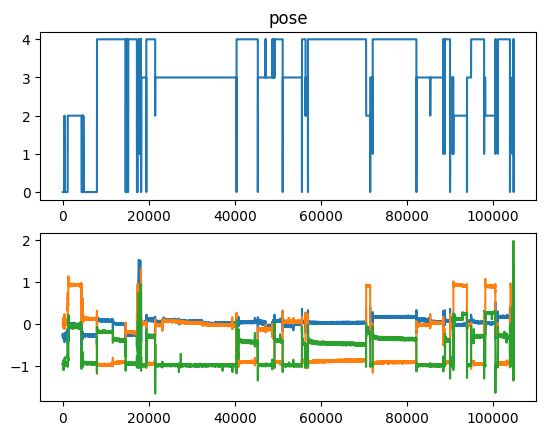

In [9]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
fp = '/content/drive/MyDrive/etc/SB솔루션/Apnea/apnea_final/data/65-231113-SMH.csv'
data = np.genfromtxt(fp, delimiter=',', skip_header=1, dtype=None, usecols=range(3,6), encoding='utf-8')  # Replace 'utf-8' with the actual encoding if differentse

arr = np.char.strip(data, '"').astype(float)

arrT = arr.T
accx = arrT[0]; accy = arrT[1]; accz = arrT[2]
accx.shape, accy.shape, accz.shape
figure; title('acc'); plot(accx); plot(accy); plot(accz);
# 가속도계 데이터를 기반으로 pitch와 roll 계산 함수
pose_arr = np.zeros(len(accx))
for i, (x, y, z) in enumerate(zip(accx, accy, accz)):
    pitch = np.arctan2(y, np.sqrt(x**2 + z**2)) * 180 / np.pi  # pitch를 도 단위로 변환
    roll = np.arctan2(x, np.sqrt(y**2 + z**2)) * 180 / np.pi  # roll을 도 단위로 변환
    # 피치와 롤을 이용하여 자세를 추출하는 함수 (upright 추가)
    # 기준을 위해 z값을 절대값으로 비교 (서 있을 때 중력가속도 z축이 9.8에 가까움)
    if z > 8:  # Z축이 거의 9.8에 가까우면 서 있는 자세 (upright)
        pose_arr[i] = 5 #'Upright'
    elif -10 <= pitch <= 10 and -10 <= roll <= 10:
        pose_arr[i] = 3 #'Supine'  # 바로 누운 자세
    elif pitch > 10:
        pose_arr[i] = 2 #'Left Side'  # 왼쪽으로 누운 자세
    elif pitch < -10:
        pose_arr[i] = 4 #'Right Side'  # 오른쪽으로 누운 자세
    elif roll > 10:
        pose_arr[i] = 1 #'Prone'  # 엎드린 자세
    else:
        pose_arr[i] = 0 #'Unknown'  # 알 수 없는 자세

figure();
subplot(211); title('pose'); plot(pose_arr)
subplot(212); plot(accx); plot(accy); plot(accz);


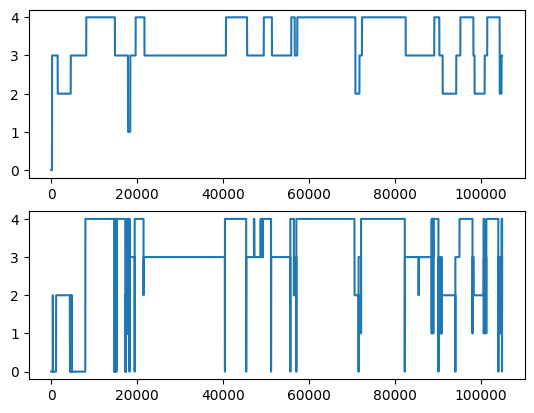

In [13]:
subplot(211); plot(pose_cur)
subplot(212); plot(pose_arr)

In [11]:
pose_cur = get_sleep_position(accx, accy, accz)

In [14]:
cap_r = np.genfromtxt(fp, delimiter=',', skip_header=1, dtype=None, usecols=(2), encoding='utf-8')
cap = np.char.strip(cap_r, '"').astype(int)
cap.shape

(104851,)

In [97]:
from datetime import datetime
time_r = np.genfromtxt(fp, delimiter=',', skip_header=1, dtype=None, usecols=(1), encoding='utf-8')
time = [datetime.strptime(t.strip('"').strip("'"), '%Y-%m-%d %H:%M:%S.%f') for t in time_r] # Slice the string to remove the last 5 characters (microseconds except the first digit)

In [45]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from datetime import datetime

In [100]:
len(time)

104851

In [103]:
peak_times = [time[i].timestamp() for i in peaks]

In [116]:
# 피크 감지 (높이 임계값 조정 가능)
peaks, _ = find_peaks(cap, height=0.3, distance=1)  # 최소 거리 임계값은 필요에 따라 조정

# Convert peaks to a 1D integer array if it's not already
#peaks = peaks.astype(int).flatten()

# 피크 간의 시간 차이 계산 (초 단위로)
peak_times = [time[i].timestamp() for i in peaks]
peak_intervals = np.diff(peak_times)

# 호흡 주기(초당 호흡 수)를 1/peak_intervals로 계산한 후, 분당 호흡수를 얻기 위해 60을 곱함
rr = 60 / peak_intervals
rr = np.append(rr, np.mean(rr))
rr.shape, rr

((23765,),
 array([150.00005364, 149.99996424,  37.50000224, ...,  60.        ,
         60.        ,  89.00590987]))

In [115]:
rr.shape, peaks.shape, len(peak_times), len(time)

((23765,), (23765,), 23765, 104851)

In [119]:
rrv = np.diff(rr)

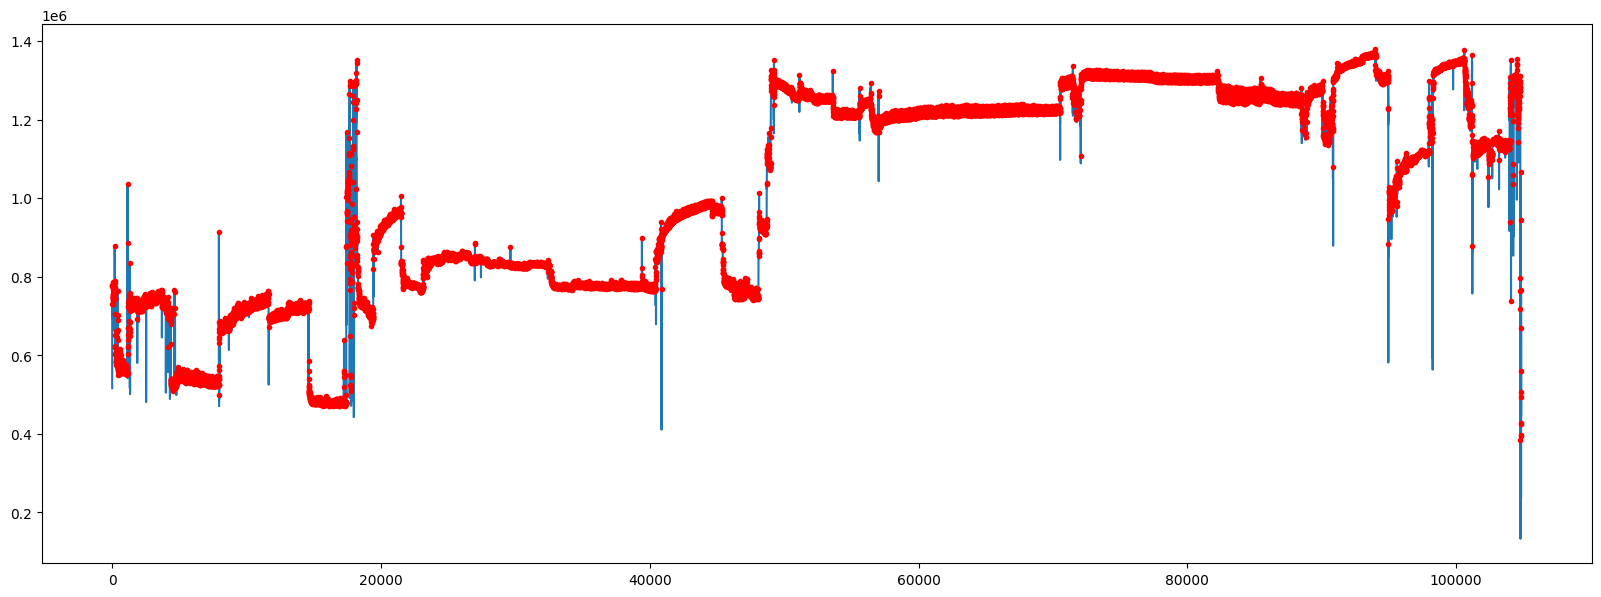

In [131]:
figure(figsize=(20,7)); plot(cap); plot(peaks, cap[peaks], 'r.'); show();

In [133]:
import numpy as np

def find_peaks_and_valleys(data, window_size):
  # 이동 평균 계산
  moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
  # 상태 변화 감지 (1: rising, -1: falling)
  state = np.sign(np.diff(moving_avg))
  # peak과 bottom 찾기
  peaks = np.where((state[:-1] == 1) & (state[1:] == -1))[0] + 1
  valleys = np.where((state[:-1] == -1) & (state[1:] == 1))[0] + 1
  return peaks, valleys

def calculate_rr(peaks, time):
  # peak 간의 시간 차이 계산 (초 단위)
  peak_times = [time[i].timestamp() for i in peaks]
  peak_intervals = np.diff(peak_times)
  # 호흡 주기(초당 호흡 수)를 1/peak_intervals로 계산한 후, 분당 호흡수를 얻기 위해 60을 곱함
  rr = 60 / peak_intervals
  return rr

# 예시
window_size = 10  # 이동 평균 윈도우 크기

# find_peaks_and_valleys 함수를 사용하여 peak과 bottom 찾기
peaks, valleys = find_peaks_and_valleys(cap, window_size)

# calculate_rr 함수를 사용하여 분당 호흡 수 계산
rr = calculate_rr(peaks, time)

# 결과 출력
print("Peaks:", peaks)
print("Valleys:", valleys)
print("Respiratory Rate:", rr)

Peaks: [     1     21     39 ... 104828 104835 104839]
Valleys: [    11     30     50 ... 104825 104831 104837]
Respiratory Rate: [15.         16.66666711 24.99999901 ... 75.00000447 42.85713994
 75.00000447]


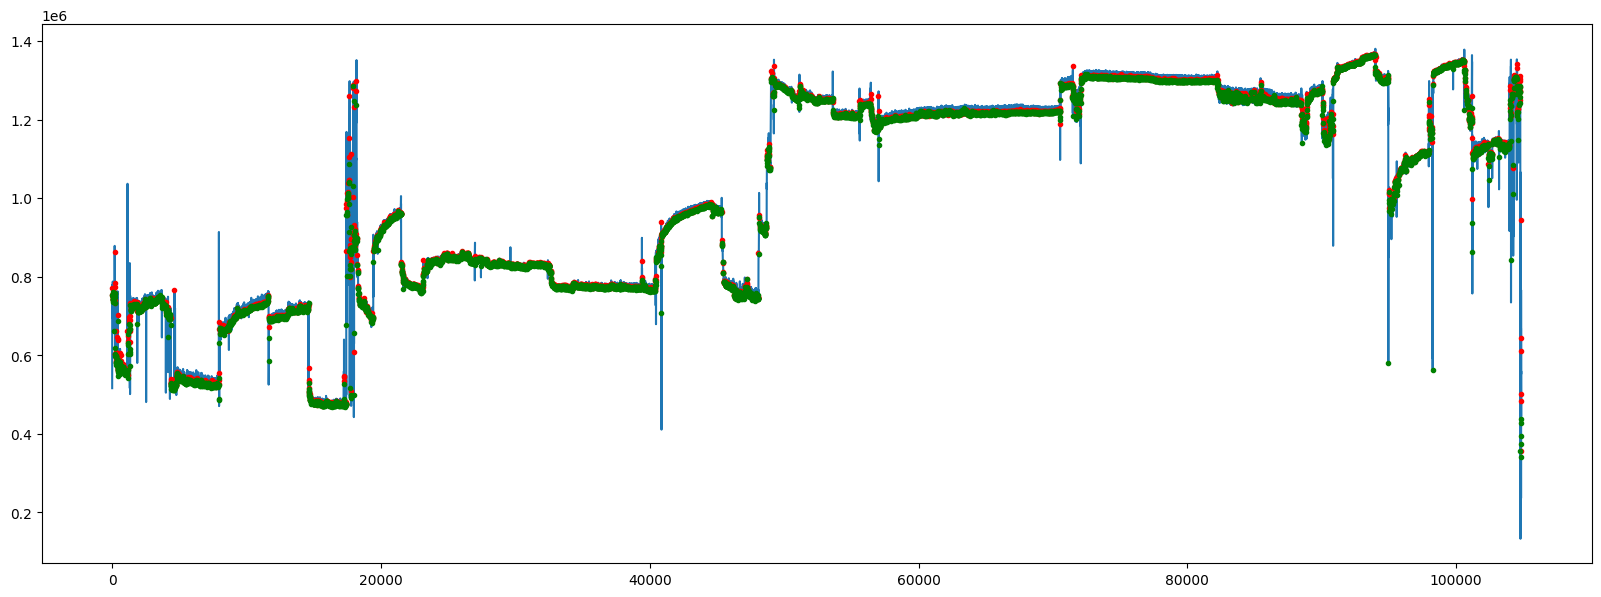

In [137]:
figure(figsize=(20,7)); plot(cap); plot(peaks, cap[peaks], 'r.'); plot(valleys, cap[valleys], 'g.');

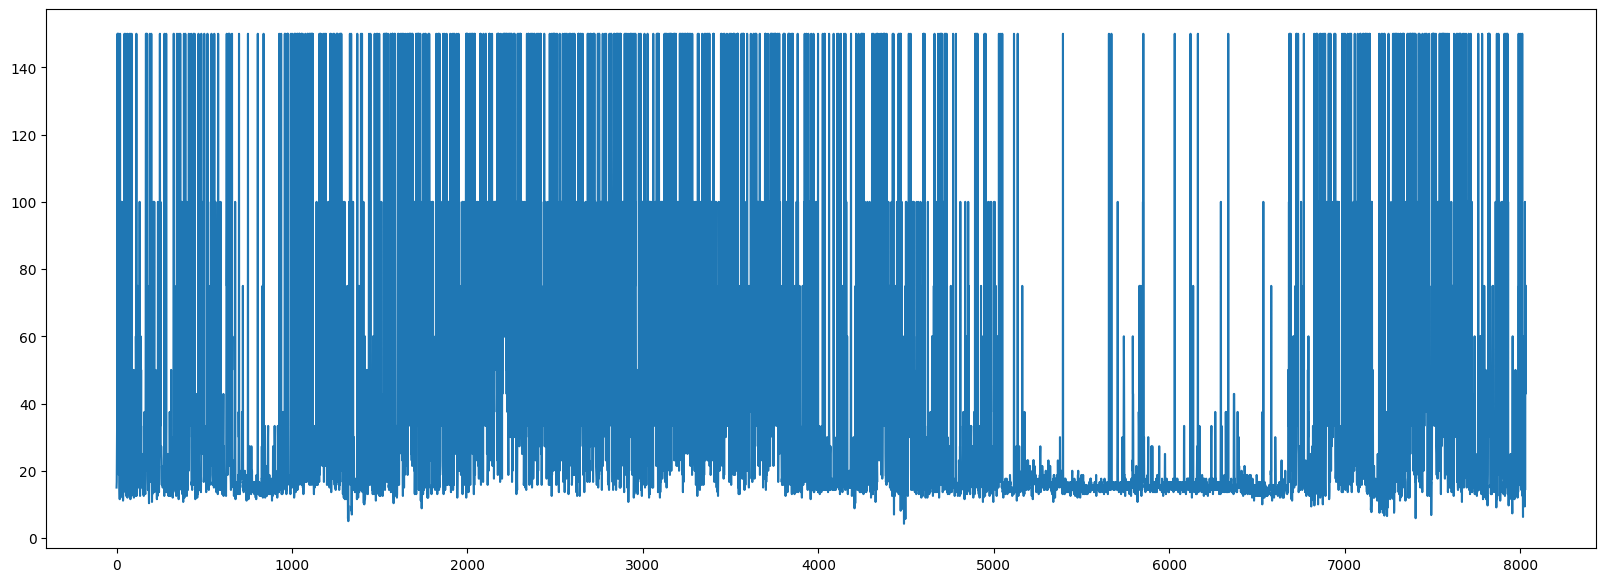

In [140]:
figure(figsize=(20,7)); plot(rr)